In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.optimize import curve_fit as cf
import pandas as pd

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
from math import floor
import scipy.stats as stats

dcmls = lambda x : -int(floor(np.log10(abs(x))))

round_error = lambda value,rounder : np.round(value,dcmls(rounder))

def chi2(y,y_err,x,func,popt):
    y_ajuste = func(x,*popt)
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    return chi_cuadrado

def chi2_red(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

def pvalue(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    pvalor = stats.chi2.sf(chi_cuadrado,grados_lib)
    return pvalor

In [4]:
from scipy.special import gamma
poisson_pmf = lambda x,mu : mu**x/gamma(x+1) * np.exp(-mu)
proba = lambda x,mu : mu**x/(1+mu)**(1+x)

In [5]:
from scipy.signal import find_peaks

In [6]:
def convertir_a_segundos(texto):
    # Dividir el texto en número y unidad
    partes = texto.split()
    numero = float(partes[0])
    unidad = partes[1]

    # Convertir a segundos según la unidad
    if unidad == 'ms':
        return numero / 1000.0
    elif unidad == 'mus':
        return numero / 1_000_000.0
    else:
        raise ValueError(f"Unidad no reconocida: {unidad}")

carpetas_posta= [1,2,'10 mus']
df_ruido=pd.read_csv('resultados_medias_desviaciones.csv')
carpetas_ruido= os.listdir()

0.0


C:\Users\olegarios098\AppData\Local\Temp\ipykernel_11740\2745429856.py:10: RuntimeWarning: divide by zero encountered in divide
  chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)


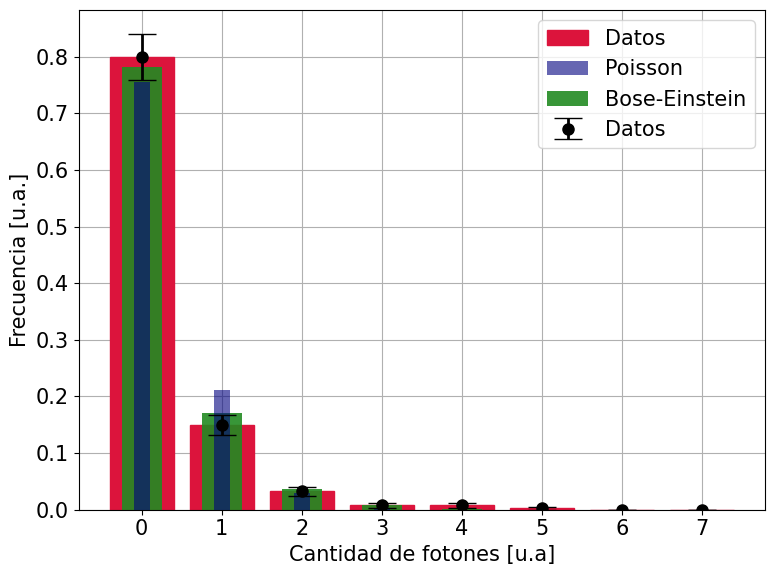

In [12]:
a=2
m=3
carpeta = carpetas_posta[a]
archivo = os.listdir(carpeta)
ventana = convertir_a_segundos(carpetas_posta[a])

# Obtener la media y desviación estándar correspondientes a la carpeta
sigr = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Desviación Estándar'].values[0]
media = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Media'].values[0]

# Calcular el umbral
umbral = media + m * sigr

def f(i):
    ruta_archivo = os.path.join(carpeta, archivo[i])
    datos = pd.read_csv(ruta_archivo)
    t = datos['t']
    v = -datos['V1']
    
    # Encontrar picos
    p = find_peaks(v, height=umbral, threshold=None, distance=20, prominence=0.01, width=None, wlen=None, rel_height=0.5, plateau_size=None)
    return t, v, p, umbral
    
picos = []

# Iterar sobre los archivos y contar los picos en cada archivo
for i in range(len(archivo)):
    t, v, p, umbral_valor = f(i)
    picos.append(len(p[0]))

# Crear histogramas
max_val = 8
bins = np.arange(-0.5, max_val + 0.5, 1)  # Bins centrados en enteros

# Histograma de los picos
counts, bin_edges = np.histogram(picos, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
mu = float(np.mean(picos))
# initial_parameters = np.mean(picos)
error = np.std(picos) / np.sqrt(len(archivo))
# fitter = likefit.Poisson(bin_centers,counts,poisson_pmf)
# fit_result = fitter.fit(initial_parameters)
# print(fitter.get_estimators(),mu)
# fitter.plot_fit()
x=np.arange(0,max_val,1)
y_poi=poisson_pmf(x,np.mean(picos))
y_bose=proba(x,np.mean(picos))
plt.figure(figsize=(8, 6))
plt.bar(bin_centers, counts, width=0.8, color='crimson', edgecolor='crimson', alpha=1,zorder=1,label='Datos')
plt.bar(x,y_poi,width=0.2,zorder=5,label='Poisson',color='navy',alpha=0.6)
plt.bar(x, y_bose, width=0.5, color='forestgreen', label='Bose-Einstein',alpha=0.9)    
plt.errorbar(bin_centers, counts,yerr=np.sqrt(counts)/22, color='black', alpha=1,zorder=10,fmt='o',markersize=8,label='Datos',capsize=10)
# plt.scatter(x,y_bose,color='forestgreen',zorder=4,label='Ajuste')
# plt.scatter(x,y_poi,color='navy',zorder=4,label='Ajuste')
plt.grid()
print(pvalue(counts,np.sqrt(counts)/22,bin_centers,poisson_pmf,[mu]))
plt.xlabel('Cantidad de fotones [u.a]')
plt.ylabel('Frecuencia [u.a.]')
plt.legend()
    # plt.savefig(f'poisson posta.png')
    # print(carpetas_posta[a])
    # # plt.title(f'Histograma de Picos para Carpeta {carpetas_posta[a]} (Umbral: {umbral})')
    
    # # Guardar gráfico
    # # Devolver los valores calculados
    # print(ventana)
    # print(sum(picos))

In [38]:
print(f'Poisson: p={pvalue(counts,errores,bin_centers,poisson_pmf,[np.mean(picos)])}, chi={chi2_red(counts,errores,bin_centers,poisson_pmf,[np.mean(picos)])}')
print(f'Bose: p={pvalue(counts,errores,bin_centers,proba,[np.mean(picos)])}, chi={chi2_red(counts,errores,bin_centers,proba,[np.mean(picos)])}')

Poisson: p=0.003197559122636253, chi=3.274769232924127
Bose: p=0.547150058013629, chi=0.8290026824905375


In [35]:
errores = np.sqrt(counts)/22
errores

array([0.04065578, 0.01760447, 0.00819443, 0.00393648, 0.00393648,
       0.00227273, 0.        , 0.        ])

In [36]:
errores[-2] = errores[-3]
errores[-1] = errores[-3]
errores

array([0.04065578, 0.01760447, 0.00819443, 0.00393648, 0.00393648,
       0.00227273, 0.00227273, 0.00227273])